In [21]:
%matplotlib widget

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

from main import flight
from main import analysis
import propellers
import motors
from aircraft import airplane
import cl_finders

In [22]:
df_100Hz = pd.read_pickle("./data/june15_2022_100Hz.pkl")
df = df_100Hz.interpolate(method="linear")

In [23]:
# Vehicle parameters
prop = propellers.aeronaut185x12() # Using aeronaut 20x8 for this flight
motor = motors.U7V2_280KV()  # Using U7 V2 motor

mass = 12.727 # Estimated with virtual bolt included
span = 6.28
chord = 0.395
createv = airplane(mass, chord, span)

P_systems = 4 # Amount of power consumed by everything except the ESC & motor

In [24]:
### Mask Initialization ###

# Generating Start/End Times for Segments #
# Producing masks for dataframe

def get_mask(df, start, end, year, month, day):
    # Getting boolean mask from start and end times
    start_time = get_datetime(start, year, month, day)
    end_time = get_datetime(end, year, month, day)
    mask = (df.index > start_time) & (df.index < end_time)
    return mask

def get_datetime(hour_string, year, month, day):
    # Results completed datetime from hour string, and date
    split_nums = hour_string.split(':')
    hours = int(split_nums[0])
    minutes = int(split_nums[1])
    seconds = int(split_nums[2])
    return pd.Timestamp(year=year, month=month, day=day, hour=hours, minute=minutes, second=seconds)

year = 2022
month = 6
day = 15

# Cruise Masking

seg_times = np.array([['08:54:36','09:04:09'],
                      ['09:04:36','09:16:09'],
                      ['09:16:11','09:26:10'],
                      ['09:26:10','09:36:09'],
                      ['09:57:40','10:02:04'],
                      ['10:02:14','10:07:21'],
                      ['10:07:29','10:17:21'],
                      ['10:18:25','10:24:34'],
                      ['10:25:52','10:27:55']])
masks = []
for i in range(np.shape(seg_times)[0]):
    mask = get_mask(df, seg_times[i,0], seg_times[i,1], year, month, day)
    masks.append(mask)

# Descending Masking

seg_times = np.array([['07:22:05','07:22:53'],
                      ['07:26:03','07:27:00'],
                      ['07:30:07','07:31:07'],
                      ['07:34:02','07:35:07'],
                      ['07:38:15','07:39:23'],
                      ['07:42:09','07:43:33'],
                      ['07:46:31','07:47:44'],
                      ['07:50:35','07:51:52'],
                      ['07:54:31','07:55:52'],
                      ['07:58:44','08:00:17'],
                      ['08:03:18','08:04:43'],
                      ['08:07:50','08:09:15'],
                      ['08:12:18','08:13:46'],
                      ['08:17:13','08:18:37'],
                      ['08:22:27','08:23:45'],
                      ['08:27:36','08:28:54'],
                      ['08:33:13','08:34:06'],
                      ['08:38:18','08:39:14'],
                      ['08:43:38','08:44:59'],
                      ['08:48:03','08:49:26']
                      ])
desc_masks = []
for i in range(np.shape(seg_times)[0]):
    mask = get_mask(df, seg_times[i,0], seg_times[i,1], year, month, day)
    desc_masks.append(mask)

In [25]:
############# Main Analysis ###############3

# Attitude 
phi = np.deg2rad(df["RollAngle"].to_numpy())            # Bank angle in radians
pitch = np.deg2rad(df["PitchAngle"].to_numpy())         # Pitch angle in radians

# Inertial Measurement Unit
U_dot = df["XAcc_IMU"].to_numpy()                       # Acceleration in X direction

# Atmospheric adjustments:
rho = df["Pressure"].to_numpy() * (287 * (df["Ambient_Temperature"].to_numpy()+273.15))**-1             # Density found from barometer pressure & airspeed sensor temperatures
v_eas = df["Airspeed_Sensor0"].to_numpy()                               # Equivalent SSL airspeed (m/s)
v_tas = v_eas * np.sqrt(1.225) * np.sqrt(rho)**-1   # the true airspeed
q = 0.5 * rho * v_tas**2                            # Dynamic pressure 

# For Descent method
h = df["Altitude_POS"].to_numpy()                   # Altitude
Vd_eas = df["DescendingXK"].to_numpy()                  # Descent Rate from EKF (is it true or EAS at SSL?)
Vd_tas = Vd_eas * np.sqrt(1.225) * np.sqrt(rho)**-1   # the true airspeed

# Ground speed limiter
v_dem = df["Airspeed_Demanded"].to_numpy()

# Propulsion characterization
n = df["MotorRPM"].to_numpy() / 60                               # Revolutions per second
i_esc = df["EscCurrent"].to_numpy()
v_esc = df["EscVoltage"].to_numpy()

df["BatteryPower"] = df["MainBatteryCurrent"] * df["MainBatteryVoltage"]
df["BatteryPower_2"] = df["MainBatteryCurrent"] * df["EscVoltage"]

# Storing the electrical power
P_esc = i_esc * v_esc
P_battery = df["BatteryPower"].to_numpy()
P_battery2 = df["BatteryPower_2"].to_numpy()


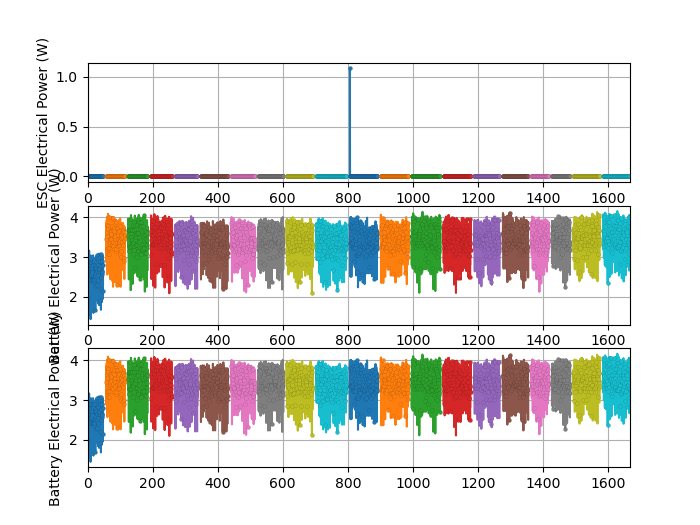

In [26]:
markerstyle = 'o'
markerevery = 80
markedgew = 0.05

plt.figure(figsize=(7,5.25))
ax1 = plt.subplot(3,1,1)
t_init = 0
for i in range(len(desc_masks)):
    time_s = np.linspace(t_init, (len(P_electical[desc_masks[i]])-1)/100 + t_init, len(P_electical[desc_masks[i]]))
    ax1.plot(time_s, P_electical[desc_masks[i]], marker=markerstyle, markevery=markerevery, markeredgecolor=[0,0,0], markersize=3, markeredgewidth=markedgew)
    t_init = time_s[-1]+10
ax1.set_ylabel("ESC Electrical Power (W)")
ax1.grid(which='major', linestyle='-')
ax1.grid(which='minor', linestyle=':', color='grey')
ax1.autoscale(enable=True, axis='x', tight=True)

ax2 = plt.subplot(3,1,2, sharex=ax1)
t_init = 0
for i in range(len(desc_masks)):
    time_s = np.linspace(t_init, (len(P_battery[desc_masks[i]])-1)/100 + t_init, len(P_battery[desc_masks[i]]))
    ax2.plot(time_s, P_battery[desc_masks[i]], marker=markerstyle, markevery=markerevery, markeredgecolor=[0,0,0], markersize=3, markeredgewidth=markedgew)
    t_init = time_s[-1]+10
ax2.set_ylabel("Battery Electrical Power (W)")
ax2.grid(which='major', linestyle='-')
ax2.grid(which='minor', linestyle=':', color='grey')
ax2.autoscale(enable=True, axis='x', tight=True)

ax3 = plt.subplot(3,1,3, sharex=ax1)
t_init = 0
for i in range(len(desc_masks)):
    time_s = np.linspace(t_init, (len(P_battery2[desc_masks[i]])-1)/100 + t_init, len(P_battery2[desc_masks[i]]))
    ax3.plot(time_s, P_battery2[desc_masks[i]], marker=markerstyle, markevery=markerevery, markeredgecolor=[0,0,0], markersize=3, markeredgewidth=markedgew)
    t_init = time_s[-1]+10
ax3.set_ylabel("Battery Electrical Power (W)")
ax3.grid(which='major', linestyle='-')
ax3.grid(which='minor', linestyle=':', color='grey')
ax3.autoscale(enable=True, axis='x', tight=True)

plt.show()